In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Q1.

```
# Psuedo Code from Monte Carlo with Exploring Starts

Init:
    pi(s);         chosen from A(s) for all states s. 
    Q(s,a);        chosen from R for all state-action pairs (s,a).
    Returns(s,a);  dictionary of mean returns (single value).
    Counts(s,a);   List to keep track of state-actions encountered.
    
While True(for each episode):
    Choose (s,a) pair so that all such pairs are picked with a non-zero probability every episode. 
    Generate episode from (S0,A0) under pi.
    Init G=0
    for t in range(0, T, -1):
        G = discount*G + R(t+1)
        Unless (St,At) appear in remaining iterations:
            Returns(s,a) = Returns(s,a) + [G - Returns(s,a)]/Counts(s,a)
            Q(St,At) = Returns(St,At)
            pi(St) = argmax(a, Q(St,At))
            Counts(St,At) += 1
```

* This incremental update is equivalent to averaging over all returns as we are weighting the total returns ,`Returns(St,At)` by `[(n-1)/n]` and the current return `G` by `1/n`. the where `n` is the number of episodes or times it has been visited (depending on First-Visit of Every-Visit MC).
* This is exactly what we do during averaging.

In [82]:
"""
Monte Carlo
"""

def MC(state_size, policy, model, episodes):
    V_values = np.zeros(shape=(2, 11, 22), dtype=np.float32)
    
    for player_usable_ace in [True, False]:
        for dealer_card in range(1, 11):
            for current_sum in range(12, 22):
                
                state = (current_sum, dealer_card, player_usable_ace)
                temp = 0
                if player_usable_ace:temp=1
                
                for episode in range(episodes):
                    """
                    We don't need to generate an episode since intermediate rewards are 0
                    and final rewards are undiscounted. 

                    Also, the state is dependent of sum which is increasing, so we also 
                    don't need to check if it repeats in an episode
                    """
                    G = 0
            #         flag = True
            #         while flag:
                    action = policy(state)
#                     print("Here")
                    reward = model(state, action) # +1, 0, -1
#                     print("Here")
                    G = reward
#                     print(state)
                    V_values[temp, dealer_card, current_sum] += reward
                    
#                     input("continue?")

                V_values[temp, dealer_card, current_sum] /= episodes

    print(V_values)
    return V_values

def MC_ES(state_size, policy, model, episodes):
    Q_values = np.zeros(shape=(2, 11, 22, 2), dtype=np.float32)
    
    for player_usable_ace in [True, False]:
        for dealer_card in range(1, 11):
            for current_sum in range(12, 22):
                for action in range(2):
                    
                    state = (current_sum, dealer_card, player_usable_ace)
                    temp = 0
                    if player_usable_ace:temp=1

                    for episode in range(episodes):
                        """
                        We don't need to generate an episode since intermediate rewards are 0
                        and final rewards are undiscounted. 

                        Also, the state is dependent of sum which is increasing, so we also 
                        don't need to check if it repeats in an episode
                        """
                        G = 0
                #         flag = True
                #         while flag:
                        action = policy(state)
    #                     print("Here")
                        reward = model(state, action) # +1, 0, -1
    #                     print("Here")
                        G = reward
    #                     print(state)
                        V_values[temp, dealer_card, current_sum] += reward

    #                     input("continue?")

                    V_values[temp, dealer_card, current_sum] /= episodes

    print(V_values)
    return V_values

In [85]:
"""
Blackjack code used for Q4.
"""
import random

class blackjackGame():
    def __init__(self):
        """
        Let hit be a 1
        and stick be 0
        """
#         Dealer policy
        self.dealer_policy = np.zeros(22)
        for i in range(0, 17):
            self.dealer_policy[i] = 1
        for i in range(17, 22):
            self.dealer_policy[i] = 0
            
#         Player Policy
        self.player_policy = np.zeros(22)
        for i in range(12, 20):
            self.player_policy[i] = 1
        self.player_policy[20] = 0
        self.player_policy[21] = 0
            
        self.player_total = 0
        self.dealer_total = 0
        self.dealer_cards = [0, 0]
        self.player_usable_ace = False
        self.dealer_usable_ace = False
        self.usable_ace_counter = 0
    
    def deal_card(self):
#         There are 13 unique card faces in total
        card = random.randint(1, 14)
        if card==1:
            return 11
        else:
            return min(card, 10)
    
    def policy(self, state):
        a, _, _ = state
        return self.player_policy[a]
        
    def model(self, initial_state, action):
        
        self.player_total = 0
        self.dealer_total = 0
        self.dealer_cards = [0, 0]
        self.player_usable_ace = False
        self.dealer_usable_ace = False
        self.usable_ace_counter = 0
        
#         State format: (current total, dealer card viewable, has a usable ace)
        self.player_total, self.deal_card_viewable, self.player_usable_ace = initial_state
        
#         print("total:", self.player_total, "viewable card:", self.deal_card_viewable, "Usable?:", self.player_usable_ace)
                
        self.dealer_cards[0] = self.deal_card_viewable
        self.dealer_cards[1] = self.deal_card()
        
        self.dealer_total = self.dealer_cards[0] + self.dealer_cards[1]
        if self.dealer_total == 22:
            self.dealer_total -= 10 # Treat 11 as 1.
            
        elif self.dealer_cards[1]!=11 and self.dealer_cards==1:
            self.dealer_total +=10
        
#         Player turn
        while True:
        
            if self.player_total==0:
                self.player_total = self.deal_card() + self.deal_card()
            if self.player_total==22:
                self.player_total -= 10 # Treat 11 as 1

            player_ace_count = 0
                
            action = self.player_policy[self.player_total]
            
#             print("Player:", self.player_total)
            
            if self.player_usable_ace:player_ace_count+=1

            if action == 1:
                new_card = self.deal_card()
                if new_card==11:
                    player_ace_count+=1

                self.player_total += new_card

                while self.player_total > 21 and player_ace_count > 0:
                    self.player_total -= 10
                    player_ace_count -= 1

                if self.player_total > 21:
#                     Bust condition.
#                     print("Player Bust!", self.player_total)
                    return -1  
                
                if player_ace_count==1:self.player_usable_ace=True
            
            else:
#                 print("Player stick!", self.player_total)
                break
                
#         Dealer Turn
        while True:
            action = self.dealer_policy[self.dealer_total]
            
            dealer_ace_count = 0
            
            if self.dealer_usable_ace:dealer_ace_count+=1
            
            if action==1:
                new_card = self.deal_card()
                if new_card==11:
                    dealer_ace_count+=1
                
                self.dealer_total += new_card
                
                while self.dealer_total > 21 and dealer_ace_count > 0:
                    self.dealer_total -= 10
                    dealer_ace_count -= 1
                
                if self.dealer_total > 21:
#                     Bust condition.
#                     print("Dealer Bust!", self.dealer_total)
                    return 1

                if dealer_ace_count==1:self.dealer_ace_count=True
        
            else:
                break
                
        
        if self.player_total > self.dealer_total:
#         Win condition
            return 1

        elif self.player_total==self.dealer_total:
#         Draw condition
            return 0
    
        else:
#         Lose condition
            return -1
            
    
    
    def plot(self, V_values):
        pass

In [87]:
A = blackjackGame()
V_vals = MC(200, A.policy, A.model, 500000)

[[[ 0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.      ]
  [ 0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.       -0.616644 -0.643444
   -0.665504 -0.690788 -0.708752 -0.729128 -0.746086 -0.764856  0.493186
    0.806466]
  [ 0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.       -0.588788 -0.615342
   -0.641664 -0.664696 -0.687368 -0.709266 -0.728692 -0.746076  0.66689
    0.890128]
  [ 0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.       -0.586656 -0.61538
   -0.64015  -0.664706 -0.686942 -0.708554 -0.724414 -0.746366  0.679486
    0.893976]
  [ 0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.   

In [157]:
"""
SARSA and Q-Learning
"""
def Q_learning(terminals, states_size, actions_size, policy, model, start,
               episodes=500, alpha=0.5, gamma=1):
    """
    Assume states are numbered 0 to whatever
    Directions are 0, 1, 2 ,3 for up, left, down, right.
    """
    Q_values = np.zeros(shape=(states_size, actions_size))
    
    accumulated_rewards = np.zeros(shape=(episodes, 1))
    
    for episode in range(episodes):
        s = start
#         print("Start:", s)
#         print("new episode!")
        r_total = 0
        counter = 0
        while(not s in terminals):
            a = policy(Q_values, s)
            s_next, r = model(s, a)
            a_greedy = np.argmax(Q_values[s_next, :])
            
            Q_values[s, a] += alpha*(r + gamma*Q_values[s_next, a_greedy] - Q_values[s, a])
            
#             print("Action:", a)
#             print("next state:", s_next)
#             print("greedy_action:", a_greedy)
            
#             print("current update:", Q_values[s, a])
#             print("target:", Q_values[s_next, a_greedy])
#             print("reward:", r)
            
            r_total += r
            counter += 1
            s = s_next
#             print("new s:", s)
            
#             print(Q_values)
#             input("continue?")
            
        
        accumulated_rewards[episode] = r_total
        
#         print(accumulated_rewards[episode], accumulated_rewards[episode-1])
        
#     print(accumulated_rewards)
    
    return accumulated_rewards
            
        
def SARSA(terminals, states_size, actions_size, policy, model, start,
               episodes=500, alpha=0.5, gamma=1):
    """
    Assume states are numbered 0 to whatever
    Directions are 0, 1, 2 ,3 for up, left, down, right.
    """
    Q_values = np.zeros(shape=(states_size, actions_size))
    
    accumulated_rewards = np.zeros(shape=(episodes, 1))
    
    for episode in range(episodes):
        s = start
        a = policy(Q_values, s)
        r_total = 0
        counter = 0
        while(not s in terminals):
            s_next, r = model(s, a)
            a_greedy = policy(Q_values, s_next)
            Q_values[s, a] += alpha*(r + gamma*Q_values[s_next, a_greedy] - Q_values[s, a])
            s = s_next
            a = a_greedy
        
            r_total += r  
            counter += 1
        
        accumulated_rewards[episode] = r_total    

#         print(accumulated_rewards[episode], accumulated_rewards[episode-1])
            
            
#     print(accumulated_rewards)            
            
    return accumulated_rewards

In [158]:
"""
Code used in Q7.
"""
import random

class cliffWalking():
    def __init__(self):
        self.state_size = 48
        self.action_size = 4
#         self.terminals = [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
        self.terminals = [47]
    
    def model(self, state, action):
        if action==0:# Up
            state -= 12
            if state < 0:
                state += 12
                
        elif action==2:# Down
            state += 12
            if state >= 48:
                state -= 12
        
        elif action==1:# Left
            if not(state==36 or state==24 or state==12 or state==0):
                state -= 1
            
        elif action==3:# Right
            if not(state==11 or state==23 or state==35 or state==47):
                state+=1
        
        else:
            print("weird action:", action)
            
        if state>36 and state<47:
            reward = -100
            state = 36
        else:
            reward = -1
            
        assert state>=0 and state<=48
            
        return state, reward
            
    def policy(self, Q_vals, state, epsilon=0.1):
        """
        The epsilon greedy policy.
        Q_vals: 2D numpy array
        state: int 0 to 47
        """

        p = random.random()

        if p <= epsilon:
            
#             print("chosen exploration")
            return random.randint(0, 3)

        else:
            
#             print("chosen greedy")
            return np.argmax(Q_vals[state])
        
    
    def plot(self, Q_learning_returns, SARSA_returns, episodes):
        plt.figure(figsize=(20, 10))
        plt.plot(range(episodes), Q_learning_returns[:,0], label='Q-Learning')
        plt.plot(range(episodes), SARSA_returns[:,0], label='SARSA')
        plt.xlabel='Sum of rewards'
        plt.ylabel='Episodes'
        plt.legend(loc='lower right')
        plt.show()

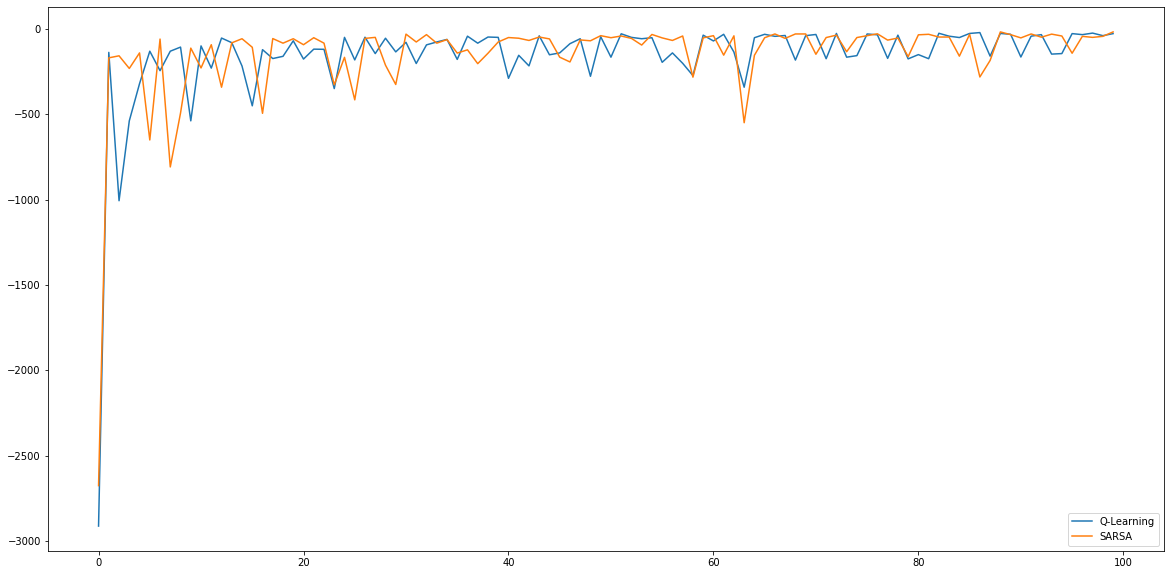

In [159]:
A = cliffWalking()
Q = Q_learning(A.terminals, A.state_size, A.action_size, A.policy, A.model, start=36, episodes=100, alpha=0.1)
S = SARSA(A.terminals, A.state_size, A.action_size, A.policy, A.model, start=36, episodes=100, alpha=0.1)
A.plot(Q, S, 100)

In [7]:
"""
TD(0) and MC
"""

def MC(state_size, action_size, terminals, model, policy, start, episodes=100, alpha=0.05, gamma=1):
    V_values = np.zeros(shape=(state_size, 1))
    for v in range(list(V_values.shape)[0]):
        V_values[v, 0] = 0.5
    
    V_values[0] = 0
    V_values[-1] = 0
    
    returns = [[] for i in range(state_size)]
    
    for episode in range(episodes):
        gen_episode = build_episode(policy)
        

def TD(state_size, action_size, terminals, model, policy, start, episodes=100, alpha=0.05, gamma=1):
    V_values = np.zeros(shape=(state_size, 1))
#     print(list(V_values.shape)[0])
#     input()
    for v in range(list(V_values.shape)[0]):
        V_values[v, 0] = 0.5
    
    V_values[0] = 0
    V_values[-1] = 0
    
    for episode in range(episodes):
        s = start
        while(not s in terminals):
            a = policy(s)
            s_next, r = model(s, a)
            V_values[s] += alpha*(r + gamma*V_values[s_next] - V_values[s])
            s = s_next
#     print(V_values)
    return V_values[1:-1]

In [8]:
"""
Code for Q6.
"""
import random
import matplotlib.pyplot as plt

class randomWalk():
    def __init__(self):
        self.state_size = 7
        self.action_size = 2
        self.terminals = [0, 6]
        
    def model(self, state, action):
        reward = 0
        if action==0:
            if state!=0:
                state-=1
        elif action==1:
            if state!=6:
                if state==5:
                    reward = 1
                    
                state += 1
        else:
            print('weird action...', action)
                
        return state, reward
    
    def policy(self, state):
        p = random.random()
        if p<=0.5:
            return 0
        else:
            return 1

    def plot_1(self, e0, e1, e10, e100):
        etrue = [1/6, 2/6, 3/6, 4/6, 5/6]
        plt.figure(figsize=(20, 10))
        plt.plot(range(1, self.state_size-1), e0, label='Episode 0')
        plt.plot(range(1, self.state_size-1), e1, label='Episode 1')
        plt.plot(range(1, self.state_size-1), e10, label='Episode 10')
        plt.plot(range(1, self.state_size-1), e100, label='Episode 100')
        plt.plot(range(1, self.state_size-1), etrue, label='True values')
        plt.xlabel('Value')
        plt.ylabel('State')
        plt.legend(loc='lower right')
        plt.show()
        

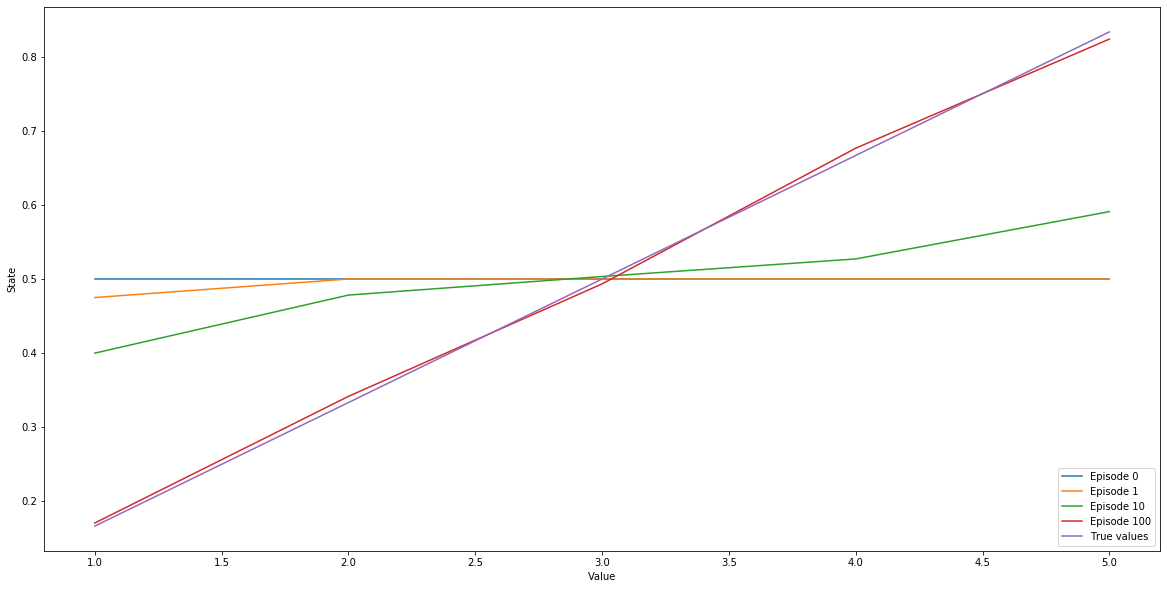

In [9]:
A = randomWalk()
V_values_0 = TD(A.state_size, A.action_size, A.terminals, A.model, A.policy, start=3, episodes=0)
V_values_1 = TD(A.state_size, A.action_size, A.terminals, A.model, A.policy, start=3, episodes=1)
V_values_10 = TD(A.state_size, A.action_size, A.terminals, A.model, A.policy, start=3, episodes=10)
V_values_100 = TD(A.state_size, A.action_size, A.terminals, A.model, A.policy, start=3, episodes=100)
A.plot_1(V_values_0, V_values_1, V_values_10, V_values_100)